# IMPORT LIBRARIES

In [25]:
import pandas as pd
import numpy as np
import datetime as dt
import re
from scipy import stats
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns

# IMPORT DATA

In [26]:
data=pd.read_excel('../Data/data-co-lien.xlsx',index_col=1)
data = data.iloc[:, 1:]

In [27]:
data

,USD/VND,EUR/VND
Ngày,,
2022-12-22,23650.0,25180.15700
2022-12-23,23612.5,25052.86500
2022-12-26,23605.0,25075.59450
2022-12-27,23600.0,25163.50100
2022-12-28,23600.0,25163.50100
...,...,...
2023-12-18,24360.0,26599.90250
2023-12-19,24357.5,26654.41375
2023-12-20,24345.0,26684.55650


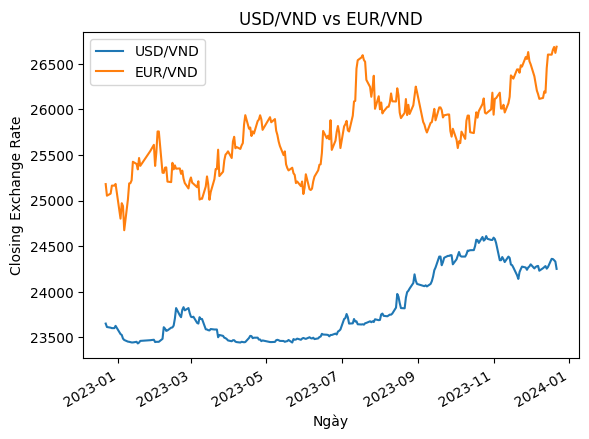

In [28]:
price = data
price.plot()
plt.title('USD/VND vs EUR/VND')
plt.ylabel('Closing Exchange Rate')
plt.show()


Text(0, 0.5, 'Daily Log Returns')

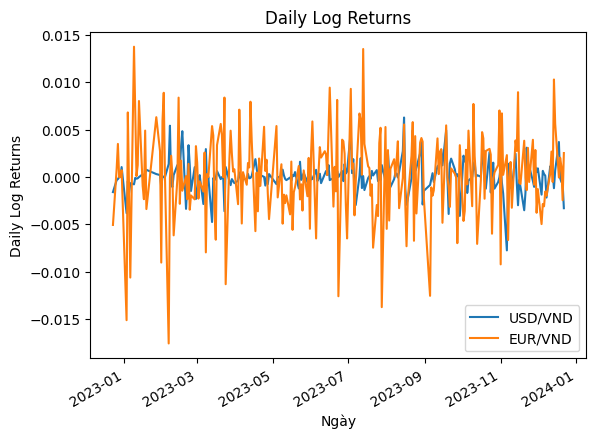

In [29]:
returns = price.pct_change().dropna()
returns.plot()
plt.title('Daily Log Returns')
plt.ylabel('Daily Log Returns')

In [30]:
return_summary = (returns).describe()
return_summary

,USD/VND,EUR/VND
count,250.000000,250.000000
mean,0.000102,0.000243
std,0.001642,0.004616
min,-0.007744,-0.017577
25%,-0.000518,-0.002328
50%,0.000000,0.000280
75%,0.000659,0.002928
max,0.006296,0.013775


# Calculate the daily log returns and drop any NAs

In [31]:
log_returns = np.log(data/data.shift(1))
log_returns.dropna(inplace=True)
print(log_returns)

             USD/VND   EUR/VND
Ngày                          
2022-12-23 -0.001587 -0.005068
2022-12-26 -0.000318  0.000907
2022-12-27 -0.000212  0.003500
2022-12-28  0.000000  0.000000
2022-12-29  0.000000  0.000000
...              ...       ...
2023-12-18  0.003701 -0.000046
2023-12-19 -0.000103  0.002047
2023-12-20 -0.000513  0.001130
2023-12-21 -0.000616 -0.002443
2023-12-22 -0.003294  0.002539

[250 rows x 2 columns]


# Create a weighted portfolio

In [32]:
quantities = [3000000, 2000000]

In [33]:
portfolio_value =  data.iloc[-1].iloc[0]*quantities[0] + data.iloc[-1].iloc[1]*quantities[1]
portfolio_value

126124256000.0

In [34]:
weights = [
    data.iloc[-1].iloc[0] * quantities[0] / portfolio_value,
    data.iloc[-1].iloc[1] * quantities[1] / portfolio_value
]
print(weights)

[0.5768121240691402, 0.4231878759308598]


# Calculate the historical portfolio returns

In [35]:
historical_returns = (log_returns*weights).sum(axis=1)
print(historical_returns)

Ngày
2022-12-23   -0.003060
2022-12-26    0.000201
2022-12-27    0.001359
2022-12-28    0.000000
2022-12-29    0.000000
                ...   
2023-12-18    0.002115
2023-12-19    0.000807
2023-12-20    0.000182
2023-12-21   -0.001389
2023-12-22   -0.000825
Length: 250, dtype: float64


# Find the X-day portfolio returns

In [36]:
days = 1

historical_x_days_returns = historical_returns.rolling(window = days).sum()
historical_x_days_returns = historical_x_days_returns.dropna()
print(historical_x_days_returns)

Ngày
2022-12-23   -0.003060
2022-12-26    0.000201
2022-12-27    0.001359
2022-12-28    0.000000
2022-12-29    0.000000
                ...   
2023-12-18    0.002115
2023-12-19    0.000807
2023-12-20    0.000182
2023-12-21   -0.001389
2023-12-22   -0.000825
Length: 250, dtype: float64


# Create a covariance matrix 

In [37]:
cov_matrix = log_returns.cov() * 252

# Calculate portfolio standard deviation

In [38]:
weights_array = np.array(weights)
portfolio_std_dev = np.sqrt(weights_array.T @ cov_matrix @ weights_array)

# Set different confidence intervals

In [39]:
confidence_intervals = [0.9, 0.95, 0.99]

# Select CI and calculate VaR

In [72]:
from scipy.stats import norm
VaRs = []
for ci in confidence_intervals: 
    VaR = portfolio_value * (norm.ppf(1 - ci) * portfolio_std_dev * np.sqrt(days / 252) - historical_returns.mean() * days)
    VaRs.append(VaR)

In [73]:
print(f'{"Confidence Interval":<20} {"Value at Risk: <20"}')
print('-' * 40)
#print each confidence interval and its corresponding VaR
for ci, VaR in zip(confidence_intervals, VaRs):
    print(f'{ci * 100:>6.0f}%: {"":<8}    {-VaR:>10,.2f}')

Confidence Interval  Value at Risk: <20
----------------------------------------
    90%:             374,234,626.32
    95%:             474,740,237.49
    99%:             663,272,049.12


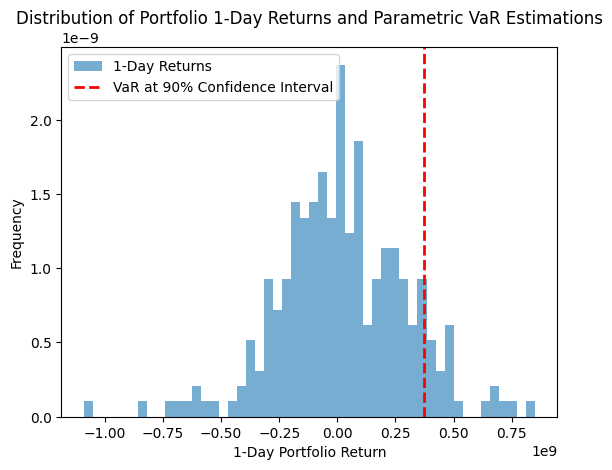

In [74]:
# Conver returns to values for histogram
historical_x_days_returns_values = historical_x_days_returns * portfolio_value

# Plot histogram
plt.hist(historical_x_days_returns_values, bins=50, density=True, alpha=0.6, label=f'{days}-Day Returns')
# Add vertical line representing VaR
plt.axvline(x=-VaRs[confidence_intervals.index(0.9)], color='r', linestyle='dashed', linewidth=2, label='VaR at 90% Confidence Interval')

plt.xlabel(f'{days}-Day Portfolio Return')  
plt.ylabel('Frequency')
plt.title(f'Distribution of Portfolio {days}-Day Returns and Parametric VaR Estimations')
plt.legend()
plt.show()


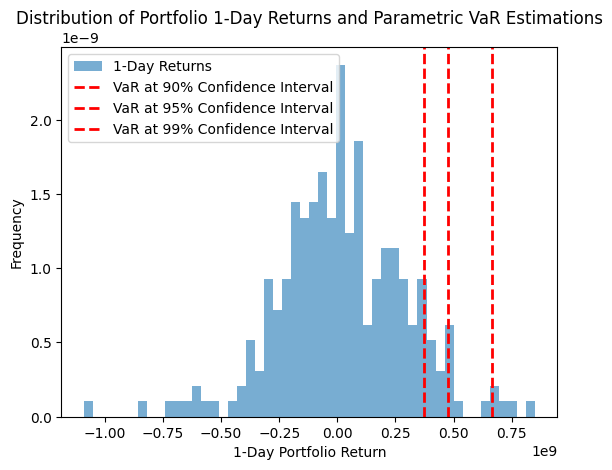

In [75]:
plt.hist(historical_x_days_returns_values, bins=50, density=True, alpha=0.6, label=f'{days}-Day Returns')
# Add vertical lines representing VaR of each CI
for ci, VaR in zip(confidence_intervals,VaRs):
    plt.axvline(x= -VaR, color='r', linestyle='dashed', linewidth=2, label='VaR at {}% Confidence Interval'.format(int(ci *100)))

plt.xlabel(f'{days}-Day Portfolio Return')  
plt.ylabel('Frequency')
plt.title(f'Distribution of Portfolio {days}-Day Returns and Parametric VaR Estimations')
plt.legend()
plt.show()